## Marek Ochocki (marcopolo97@vp.pl) i Łukasz Gosek (lukaszjgosek@gmail.com)

# Zadanie 2

Reading data from DB

In [1]:
import pandas as pd

df = pd.read_csv("Bias_correction_ucl.csv", parse_dates=True)

# removing rows with missing values
df = df.dropna().reset_index(drop=True)

# splitting Date column to three colums: year, month, day
df['Year'] = [float((str(d)).split('-')[0]) for d in df['Date']]
df['Month'] = [float((str(d)).split('-')[1]) for d in df['Date']]
df['Day'] = [float((str(d)).split('-')[2]) for d in df['Date']]
df.drop(['Date'], axis=1, inplace=True)

# separating targets from features
target_names = ['Next_Tmax', 'Next_Tmin']

target = df[target_names]
features = df.drop(target_names, axis=1)

Splitting data into train and test sets

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=42) 

Applying standarization to data

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Function encapsulating model creation process

In [14]:
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers


def create_model(num_layers=2, layer_size=30, lr=0.01):
    network = models.Sequential()
    network.add(layers.Dense(layer_size,
                             activation='relu',
                             input_shape=(25,),
                             kernel_regularizer=regularizers.l2(0.0001),
                             activity_regularizer=regularizers.l1(0.0001)))
    for i in range(num_layers-1):
        network.add(layers.Dense(layer_size,
                                 activation='relu',
                                 kernel_regularizer=regularizers.l2(0.0001),
                                 activity_regularizer=regularizers.l1(0.0001)))
    network.add(layers.Dense(2))
    
    adam = optimizers.Adam(lr=lr)

    network.compile(optimizer=adam,
                    loss='mean_absolute_error')
    
    return network

Using 5-fold cross validation to select best model (metric - mean absolute error)

In [16]:
from sklearn.model_selection import KFold
import numpy as np


num_layers = [1, 2, 3]
layer_size = [20, 30, 50]

n_split=5

min_loss = np.inf
best_num = None
best_size = None

for num in num_layers:
    for size in layer_size:
        print(f"Number of layers: {num}, layer size: {size} ")
        maes = []
        for train_index, valid_index in KFold(n_split).split(X_train):
            print('.', end='')
            X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
            y_train_fold, y_valid_fold = y_train.to_numpy()[train_index], y_train.to_numpy()[valid_index]

            network = create_model(num_layers=num, layer_size=size)
            history = network.fit(X_train, y_train, validation_data=(X_valid_fold, y_valid_fold), epochs=500, batch_size=100, verbose=0)
            maes.append(history.history['val_loss'][-1])
    
        mean_mae = np.mean(maes)
        if mean_mae < min_loss:
            min_loss = mean_mae
            best_num = num
            best_size = size
        print()
            

print(f"Best estimator: number of layers: {best_num}, layer size: {best_size}, mean MAE: {min_loss}")

Number of layers: 1, layer size: 20 
.....
Number of layers: 1, layer size: 30 
.....
Number of layers: 1, layer size: 50 
.....
Number of layers: 2, layer size: 20 
.....
Number of layers: 2, layer size: 30 
.....
Number of layers: 2, layer size: 50 
.....
Number of layers: 3, layer size: 20 
.....
Number of layers: 3, layer size: 30 
.....
Number of layers: 3, layer size: 50 
.....
Best estimator: number of layers: 2, layer size: 50, mean MAE: 0.6161636893988834


Training a optimal network an full training set

In [17]:
model = create_model(num_layers=best_num, layer_size=best_size)
history = model.fit(X_train, y_train, epochs=500, batch_size=100, verbose=1)

Epoch 1/500
6070/6070 [==============================] - 1s 194us/step - loss: 8.5426
Epoch 2/500
6070/6070 [==============================] - 0s 19us/step - loss: 3.0485
Epoch 3/500
6070/6070 [==============================] - 0s 18us/step - loss: 2.4606
Epoch 4/500
6070/6070 [==============================] - 0s 18us/step - loss: 2.1841
Epoch 5/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.9888
Epoch 6/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.8672
Epoch 7/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.7669
Epoch 8/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.6867
Epoch 9/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.6462
Epoch 10/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.5656
Epoch 11/500
6070/6070 [==============================] - 0s 18us/step - loss: 1.5643
Epoch 12/500
6070/6070 [==============================] - 0s 1

Visualizing learning process

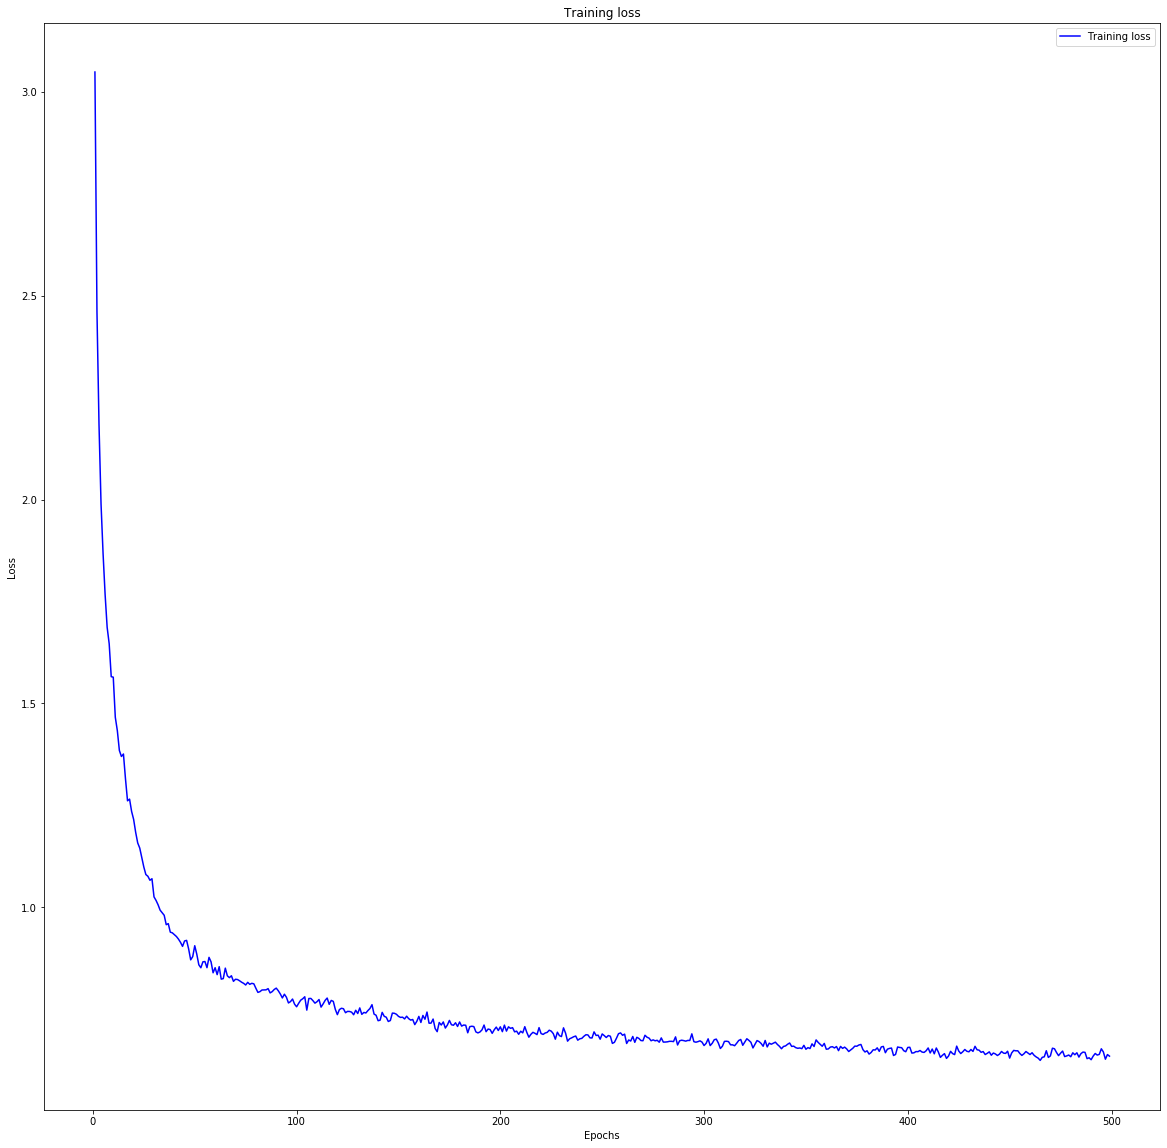

In [18]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    loss = history.history['loss'][1:]

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(20,20))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    
plot_loss_acc(history)

Using best model to make predictions for test data and calculate mean absolute error

In [19]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_test)
mean_absolute_error(y_test, preds)

0.5849131008067778